In [1]:
import numpy as np
import trackpy as tp
import nplocate as nl
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.size'] = 18

# How to use nplocate


This notebook is a practical guide on using `nplocate`


## Load the image

A handy function `fix_intensity` is provided, to fix the uneven voxel intensity along the z-direction.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


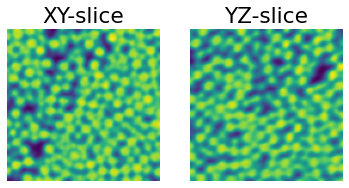

In [2]:
img = np.load('data.npy')
img = nl.utility.hist_match_1d(img, axis=2)   # fix intensity decay along z axis
img = ndimage.gaussian_filter(img, 1.5) # apply Gaussian filter to remove noise

plt.subplot(121).imshow(img[:, :, 50].T)
plt.title('XY-slice')
plt.axis('off')
plt.subplot(122).imshow(img[50])
plt.title('YZ-slice')
plt.axis('off')
plt.show()

## Get initial estimation of particle positions

Now let us use the very well written particle tracking package [trackpy](https://github.com/soft-matter/trackpy) to find some initial locations of the particles.

We need to give `trackpy` an estimation of the particle diameter.

In `nplocate` there is a nice tool called `see_slice` that allows one the examine the tracking results. The output image is an *exact* representation if there were spherical particles in a particle 2D slice.

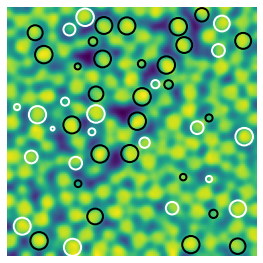

In [3]:
diameter = 9
xyz = tp.locate(img, diameter=diameter)

# convert trackpy output to a numpy array, shape (n, 3)
xyz = np.array(xyz)[:, :3]  

# preview the reuslt
nl.see_slice(img, xyz, s=20, radius=4.5, axis=2, sizes=(4, 4))

## Creating the model

The tracking is not great! Let's use the `GaussianSphere` model in `nplocate` to get very good results.

There are 3 parameters for the model,

- `r`: the radius of the sphere
- `sxy`: the extra Gaussian blur applied to the sphere in the X and Y directions
- `sz`: the extra Gaussian blur applied to the sphere in the Z directions

There is a method `fit_shape` to get the optimum values automatically, but it is very slow. Practically I just manually adjust the parameters to match the measurement.

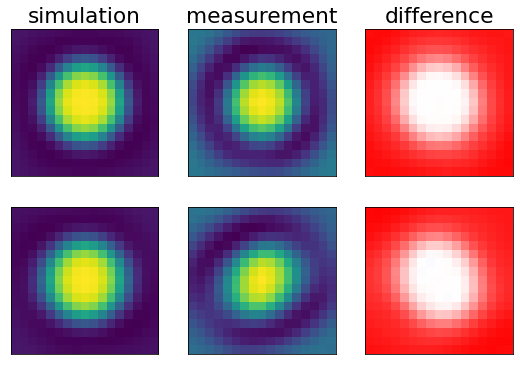

In [4]:
model = nl.GaussianSphere(r=4.8, sxy=1.2, sz=1.5)

# model.fit_shape(img, xyz)  # SLOW!

# compare the model with the measurement from real data
model.plot_mean_shape(img, xyz)

In [5]:
model

Model for mono dispersed spherical particles.
The model is a solid sphere, blurred with anisotropic Gaussian PSF.

The radius of the solid sphere      : 4.8000
The sigma values of the Gaussian PSF: (1.2000, 1.2000, 1.5000)

[nplocate.model.GaussianSphere at {'0x7f862964f7d0'}]

## Find More particles


There is a method `find_extra_particles` that does exactly its job.

iteration:  0


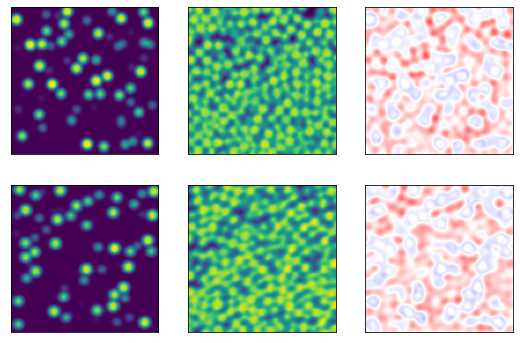


iteration:  1


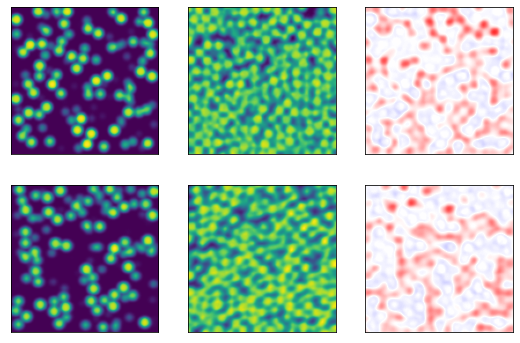


iteration:  2


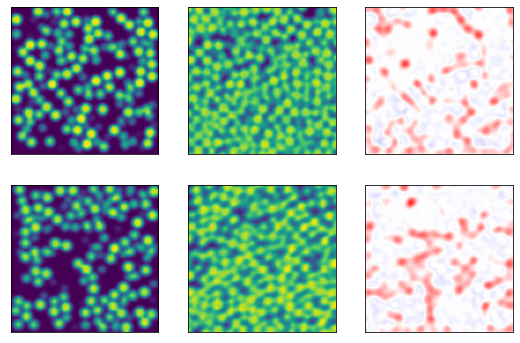


iteration:  3


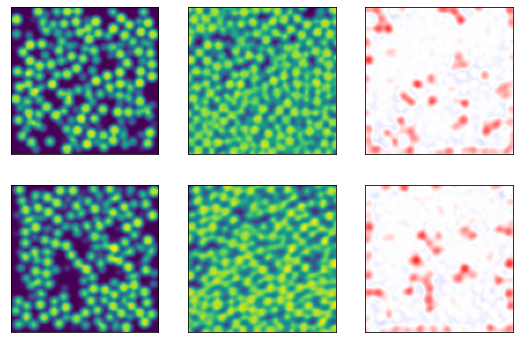


iteration:  4


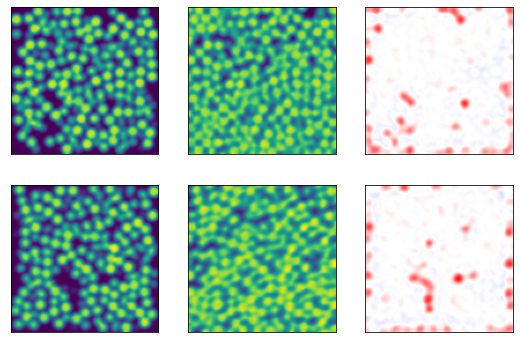


iteration:  5


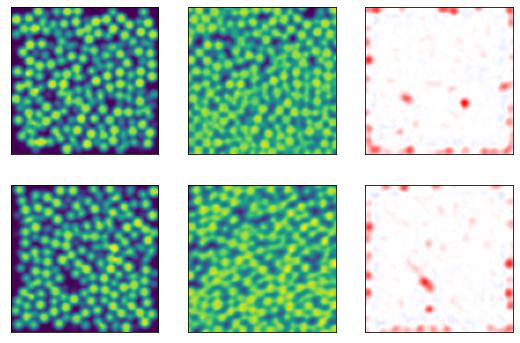


iteration:  6


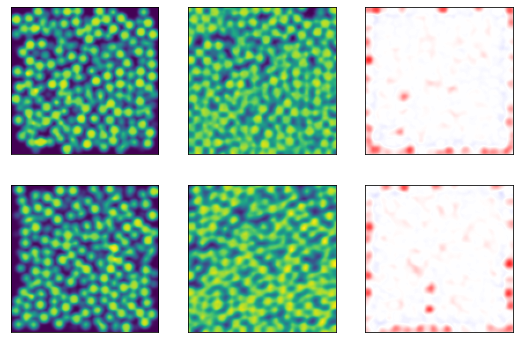


iteration:  7


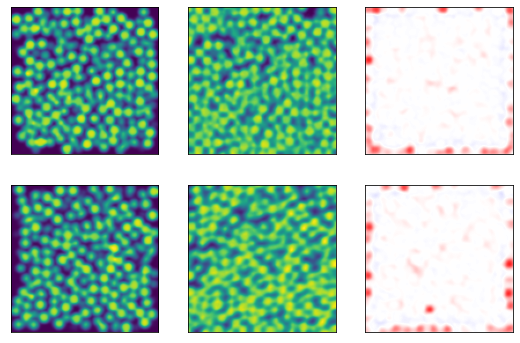


iteration:  8


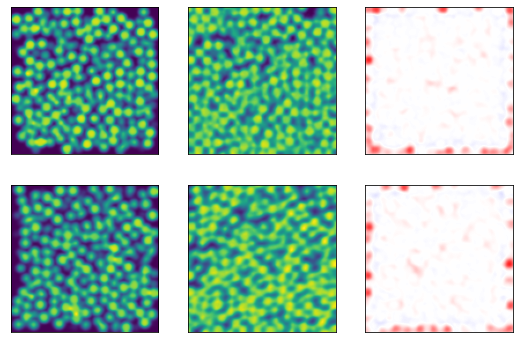

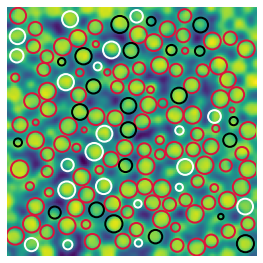

In [6]:
extra_particles = model.find_extra_particles(
    locate_func=lambda x : np.array(tp.locate(x, diameter=9))[:, :3],
    image=img,
    positions=xyz,
    diameter=8,  # forbid particles whose distance is smaller than diameter
    plot=True,   # plot the cross-correlation map in each iteration
    max_iter=20,  # the function will run recursively, with a maximum iter number
    threshold=40,
)

# combine the extra particles
xyz_opt = np.concatenate((extra_particles, xyz), axis=0)

# see the result
nl.see_slice(
    img, xyz_opt, s=10, radius=4.5, sizes=(4, 4), axis=2,
    highlight=np.arange(len(extra_particles)),
    highlight_color='crimson',
)

It's clear that more particles were found in every iteration, and the final result looks very good.

In [7]:
xyz_opt.shape, xyz.shape

((2091, 3), (575, 3))

We end up with 2000+ particles, comparing with the 600+ particles that we began with.

## Refine the positions

The common problem for particle tracking is the lack of sub-pixel precision. Typically, if we plot the decimal part of the coordinates, we clearly see they cluster near the corners.

This is physically impossible because the corners corresponds to the discrete grids during imaging, and these grids should not affect the particle position.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


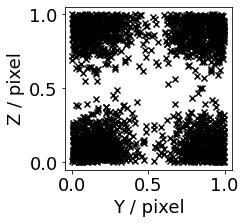

In [8]:
plt.scatter(*xyz_opt[:, 1:].T % 1.0, color='k', marker='x', label='Before Fitting')
plt.xlabel('Y / pixel')
plt.ylabel('Z / pixel')
plt.gcf().set_size_inches(3, 3)
plt.show()

This problem can be fixed by fitting the entire image, knowing the shape of the particles (ie our model).

This is possible via the `fit_positions` method of the `GaussianSphere` model.

(P.S. This takse a lot of time)

In [9]:
xyz_fit = model.fit_positions(img, xyz_opt, max_iter=5)

         Current function value: 2521243844.795154
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10


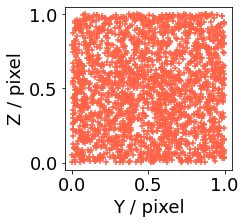

In [10]:
plt.scatter(*xyz_fit[:, 1:].T % 1.0, marker='+', color='tomato', label='After Fitting')
plt.xlabel('Y / pixel')
plt.ylabel('Z / pixel')
plt.gcf().set_size_inches(3, 3)
plt.show()

The distribution is nicely uniform now!


## Check the result

Let us compare the results before and after the fitting.

(The red spheres were found by nplocate, the black and white circles were found by trackpy)

Before fitting


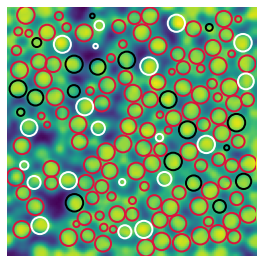

After fitting


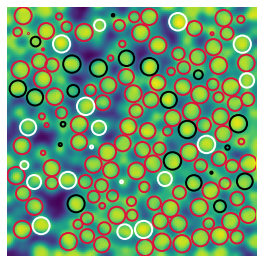

In [11]:
s = 50
axis=2

print("Before fitting")
nl.see_slice(
    img, xyz_opt, s=s, radius=4.5, sizes=(4, 4), axis=axis,
    highlight=np.arange(len(extra_particles)),
    highlight_color='crimson'
)

print("After fitting")
nl.see_slice(
    img, xyz_fit, s=s, radius=4.5, sizes=(4, 4), axis=axis,
    highlight=np.arange(len(extra_particles)),
    highlight_color='crimson',
)

It is hard to tell which one is better. A more objective way is to calculate the radial distribution function, aka g of r, of these coordinates.

The `nplocate` package offered a function `get_gr` that would calculate the g_r given the coordinates. Let us compare the results obtained in different ways

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


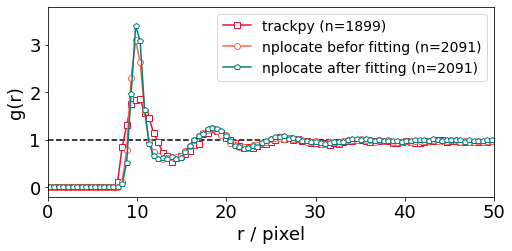

In [12]:
xyz_tp = np.array(tp.locate(img, diameter=7))[:, :3]
plt.plot(
    *nl.get_gr(xyz_tp, 50, bins=100),
    label=f'trackpy (n={xyz_tp.shape[0]})',
    color='crimson', marker='s', mfc='w'
)
plt.plot(
    *nl.get_gr(xyz_opt, 50, bins=100),
    label=f'nplocate befor fitting (n={xyz_opt.shape[0]})',
    marker='o', mfc='w', color='tomato'
)
plt.plot(
    *nl.get_gr(xyz_fit, 50, bins=100),
    label=f'nplocate after fitting (n={xyz_fit.shape[0]})',
    marker='p', mfc='w', color='teal'
)
plt.plot((0, 150), (1, 1), color='k', ls='--', zorder=0)
plt.xlim(0, 50)
plt.ylim(-0.2, 3.8)
plt.gcf().set_size_inches(8, 3.5)
plt.legend(fontsize=14)
plt.xlabel("r / pixel")
plt.ylabel("g(r)")
plt.show()

It looks like the `nplocate` find a better coordinates, especially after fitting, because its first peak reaches the is the highest.


<big><font color='red'>Warning: this document is not claiming that `nplocate` is better than `trackpy`. In fact, the comparision is not fair because I did not process the image to its best form for `trackpy`, and I did not fine-tune the parameters of `trackpy.locate`.</font></big>